In [10]:
library(dplyr) # new

library(ggplot2)
library(ggplot2)
library(ggpubr)
library(cowplot)
library(hexbin)
library(reshape2)

near_far = 20 #ang
high_lowGI = 2.5


dbNSFP3 = read.csv('../data//dbNSFP3.2.clinvar_clean.txt',header=T,sep='\t')
head(dbNSFP3)
clinvar = read.csv('../data/clinvar_glycoproteins_distances.txt',sep='\t',row.names = 1)
head(clinvar)


,idx,X.chr,pos.1.based.,ref,alt,aaref,aaalt,rs_dbSNP146,hg19_chr,hg19_pos.1.based.,⋯,ExAC_nonpsych_SAS_AF,clinvar_rs,clinvar_clnsig,clinvar_trait,clinvar_golden_stars,Interpro_domain,GTEx_V6_gene,GTEx_V6_tissue,clean_clinvar_clnsig,clinvar_pathogenic
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,0,1,1014143,C,T,Q,X,rs786201005,1,949523,⋯,.,rs786201005,5,Immunodeficiency 38,0,Ubiquitin domain|Ubiquitin-related domain,.,.,5,pathogenic
2,1,1,1014359,G,T,E,X,rs672601312,1,949739,⋯,0,rs672601312,5,Immunodeficiency 38,0,Ubiquitin domain|Ubiquitin-related domain,.,.,5,pathogenic
3,2,1,1041582,C,T,Q,X,rs587777299,1,976962,⋯,.,rs587777299,5,"Myasthenic syndrome, congenital, with pre- and postsynaptic defects",0,Kazal domain,.,.,5,pathogenic
4,3,1,1041583,A,G,Q,R,rs150359724,1,976963,⋯,6.325e-05,rs150359724,3,not specified,0,Kazal domain,.,.,3,likely benign
5,4,1,1044368,A,T,E,V,rs113288277,1,979748,⋯,2.043e-02,rs113288277,2,not specified,1,Kazal domain,.,.,2,benign
6,5,1,1046833,G,C,L,F,rs150132566,1,982213,⋯,3.418e-03,rs150132566,3,not specified,0,.,.,.,3,likely benign


,aa,protein,clinvar_path,aa_change,clinvar_index,distance_to_feature
,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>
43995,400,P01009,benign,E=>D,10919,2.88
40668,209,O75503,likely pathogenic,Y=>D,9672,3.38
70385,232,Q9GZU1,pathogenic,T=>P,16935,3.45
67684,117,P02766,pathogenic,A=>S,16442,3.51
155157,550,P48029,likely benign,T=>S,37763,3.61
67676,84,P02766,pathogenic,F=>L,16433,3.76


In [2]:
aa_class2 = read.csv('../../annotation/03_Regressions_MutualInformation/glyco_impact.0.5.csv')
aa_class = data.frame(substitution=c(paste(aa_class2$Var1,aa_class2$Var2,sep='=>'),paste(aa_class2$Var2,aa_class2$Var1,sep='=>')),
                      glyco_distance = aa_class2$glyco_dist,Blosum64 = aa_class2$value,
                      glyco_impact = ifelse(aa_class2$glyco_dist<high_lowGI,'low','high'),
                      proteinStruct_impact = ifelse(aa_class2$value>=0,'negligable - frequent','deleterious - rare'))


aa_class = aa_class[grepl('_aa$',aa_class2$v1),]

m = merge(clinvar,aa_class,by.x='aa_change',by.y='substitution')
head(m,n=10)

                    

,aa_change,aa,protein,clinvar_path,clinvar_index,distance_to_feature,glyco_distance,Blosum64,glyco_impact,proteinStruct_impact
,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,A=>E,558,Q12809,pathogenic,32009,37.05,0.6291218,-1,low,deleterious - rare
2,A=>E,558,Q12809,pathogenic,32009,37.05,0.6291218,-1,low,deleterious - rare
3,A=>E,38,P55064,pathogenic,7527,24.64,0.6291218,-1,low,deleterious - rare
4,A=>E,38,P55064,pathogenic,7527,24.64,0.6291218,-1,low,deleterious - rare
5,A=>E,362,P09172,pathogenic,34573,20.92,0.6291218,-1,low,deleterious - rare
6,A=>E,362,P09172,pathogenic,34573,20.92,0.6291218,-1,low,deleterious - rare
7,A=>E,718,Q12809,benign,31717,81.41,0.6291218,-1,low,deleterious - rare
8,A=>E,718,Q12809,benign,31717,81.41,0.6291218,-1,low,deleterious - rare
9,A=>E,292,P08100,pathogenic,25899,20.66,0.6291218,-1,low,deleterious - rare


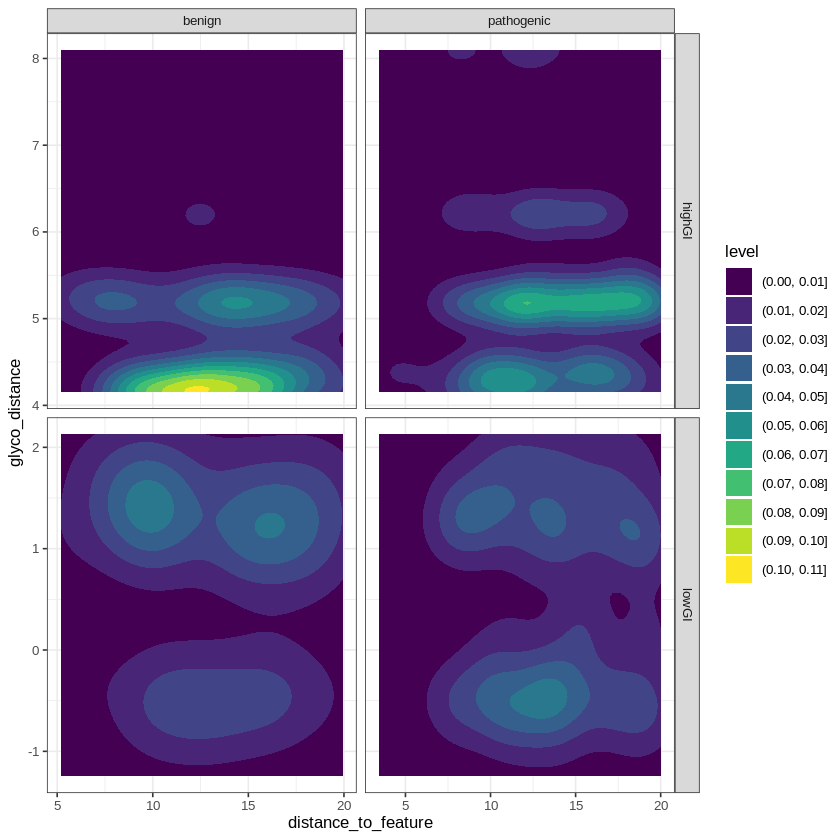

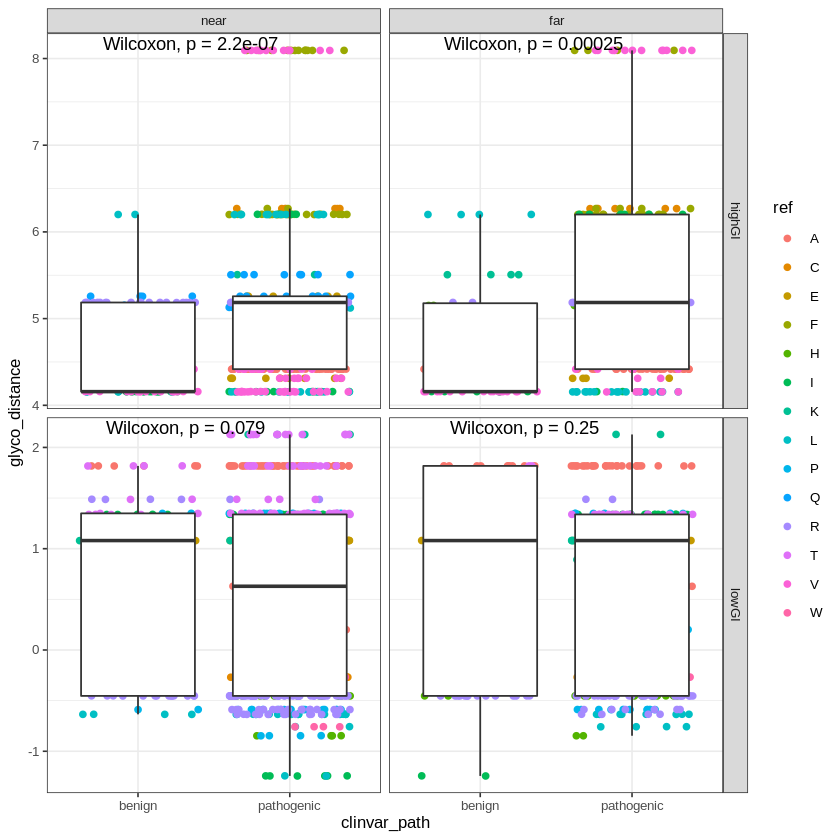

In [3]:


m2 = m
m2$ref=substr(m2$aa_change,1,1)
m2$mut=substr(m2$aa_change,4,4)
m2$GI = factor(ifelse(m2$glyco_distance>=high_lowGI,'highGI','lowGI'),level=c('highGI','lowGI'))
m2$dist2glycosite = factor(ifelse(m2$distance_to_feature>near_far,'far','near'),level=c('near','far'))

keep= m2$Blosum64>=(-2) & m2$clinvar_path %in% c('pathogenic','benign') & m2$distance_to_feature<30 #& m2$distance_to_feature<=10
m2$include = keep

g1=ggplot(na.omit(m2[keep&m2$dist2glycosite=='near',]),aes(x=distance_to_feature,y=glyco_distance))+
    geom_density2d_filled()+
    theme_bw(base_size=10)+
    facet_grid( GI ~ clinvar_path ,scale='free')#+

g4=ggplot(na.omit(m2[keep,]),aes(x=clinvar_path,y=glyco_distance))+
    geom_jitter(aes(color=ref),alpha=1)+
    geom_boxplot(outlier.shape = NA)+
    facet_grid( GI ~ dist2glycosite,scale='free')+
    stat_compare_means()+
    theme_bw(base_size=10)

g1

g4 


ggsave(g1,file='../../figures/04.specific_questions/glycoclinvar/distribution.near.pdf',height=10,width=10)
ggsave(g4,file='../../figures/04.specific_questions/glycoclinvar/distribution.boxplots.pdf',height=10,width=10)

write.table(m2,file='../../figures/04.specific_questions/glycoclinvar/distribution.near.tsv',row.names=F)
